# Model Comparison Report by Experiment Type

This report compares the performance of all models under the `data/predictions` directory, grouped by experiment type (rag, zeroshot, fewshot, cot). For each experiment, a table and line graphs are provided to visualize the metrics (correct_instances, total_instances, comet_score, meta_score) per language for each model.

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

base_dir = "./data/predictions"
models = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
experiment_map = {
    "rag": ["rag-wikidata", "rag-wikidata-entity-type-matching"],
    "zeroshot": ["zero-shot", "zero_shot", "zero-shot-1", "zero-shot-2", "zero_shot_longer_prompt"],
    "fewshot": ["few-shot", "few(3)_shot", "few(3)_shot_longer_prompt", "one_shot_longer_prompt"],
    "cot": ["cot"]
}

# Collect results: {experiment: {model: {lang: metrics_dict}}}
results = {}
for exp_group, exp_folders in experiment_map.items():
    results[exp_group] = {}
    for model in models:
        model_dir = os.path.join(base_dir, model, "validation")
        found = False
        for exp_folder in exp_folders:
            exp_path = os.path.join(model_dir, exp_folder, "scores")
            if os.path.isdir(exp_path):
                found = True
                break
        if not found:
            continue
        results[exp_group][model] = {}
        for exp_folder in exp_folders:
            exp_path = os.path.join(model_dir, exp_folder, "scores")
            if not os.path.isdir(exp_path):
                continue
            for fname in os.listdir(exp_path):
                if fname.endswith(".json"):
                    lang = fname.replace(".json", "")
                    with open(os.path.join(exp_path, fname), "r", encoding="utf-8") as f:
                        data = json.load(f)
                        results[exp_group][model][lang] = {
                            "correct_instances": data.get("correct_instances", 0),
                            "total_instances": data.get("total_instances", 0),
                            "comet_score": data.get("comet_score", None),
                            "meta_score": data.get("meta_score", None)
                        }


## Rag Experiment

### Correct Instances Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT,ja_JP,ko_KR,th_TH,tr_TR,zh_TW
0,facebook_nllb_200_3.3b,405,344,393,405,436,331,394,234,386,239
1,gemma3_instruct_4b_text,503,498,537,468,546,525,501,410,445,411



### Total Instances Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT,ja_JP,ko_KR,th_TH,tr_TR,zh_TW
0,facebook_nllb_200_3.3b,722,731,739,724,730,723,745,710,732,722
1,gemma3_instruct_4b_text,722,731,739,724,730,723,745,710,732,722



### COMET Score Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT,ja_JP,ko_KR,th_TH,tr_TR,zh_TW
0,facebook_nllb_200_3.3b,0.900469,0.880849,0.902992,0.888537,0.914546,0.892243,0.905956,0.853740,0.919268,0.853816
1,gemma3_instruct_4b_text,0.913272,0.909666,0.929734,0.900043,0.922269,0.928758,0.919779,0.871904,0.914075,0.902246



### Meta Score Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT,ja_JP,ko_KR,th_TH,tr_TR,zh_TW
0,facebook_nllb_200_3.3b,56.094183,47.058824,53.179973,55.939227,59.726027,45.781466,52.885906,32.957746,52.73224,33.102493
1,gemma3_instruct_4b_text,69.667590,68.125855,72.665765,64.640884,74.794521,72.614108,67.248322,57.746479,60.79235,56.925208


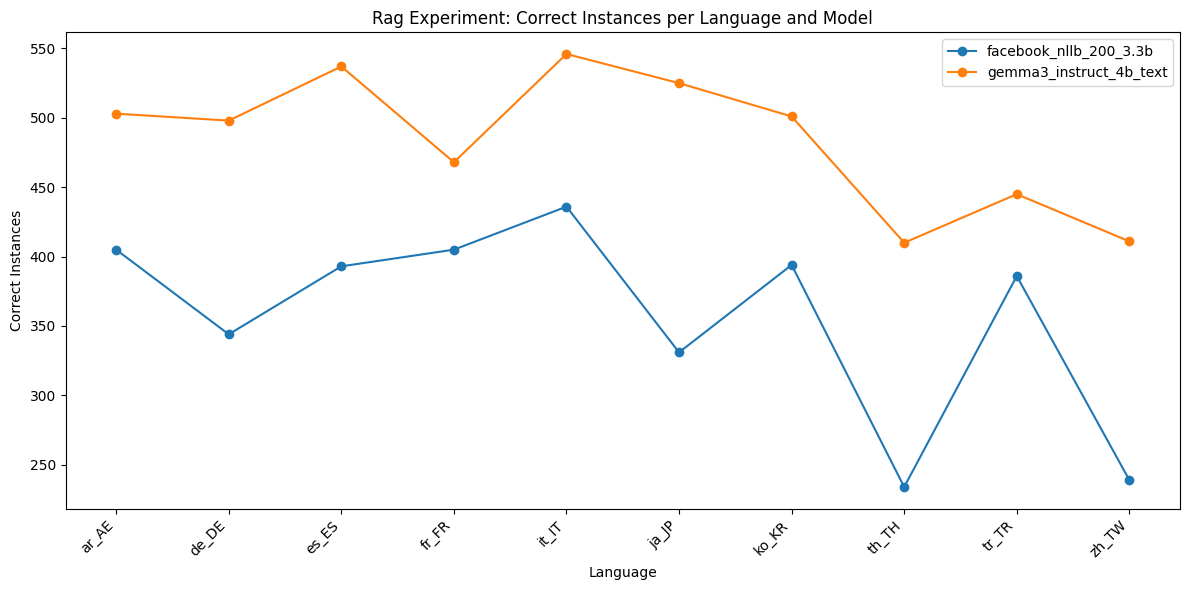

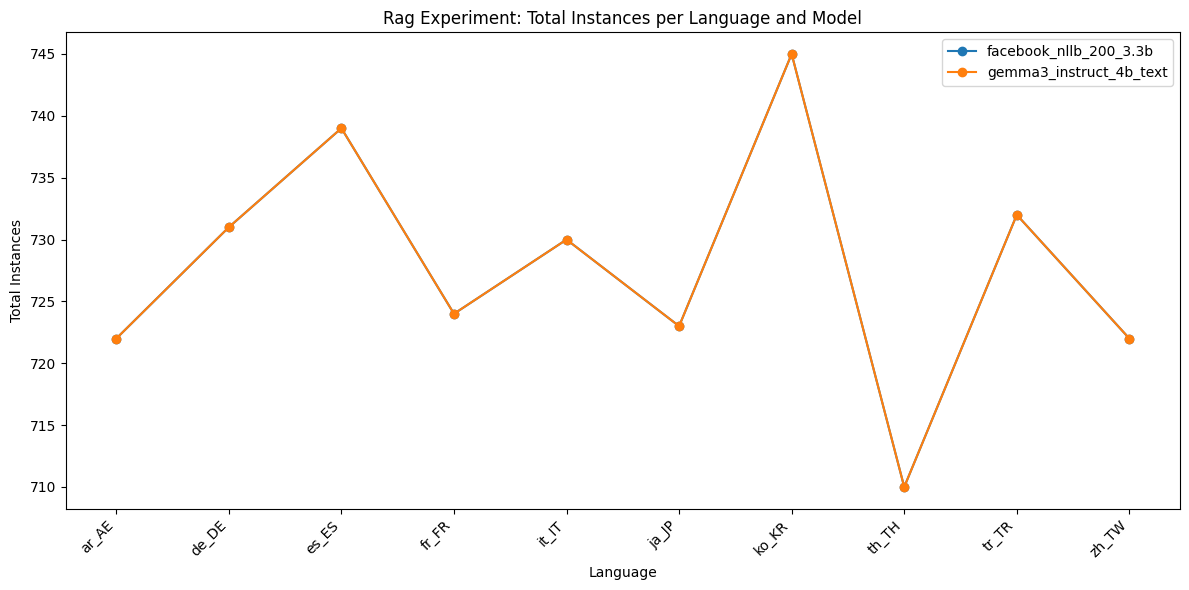

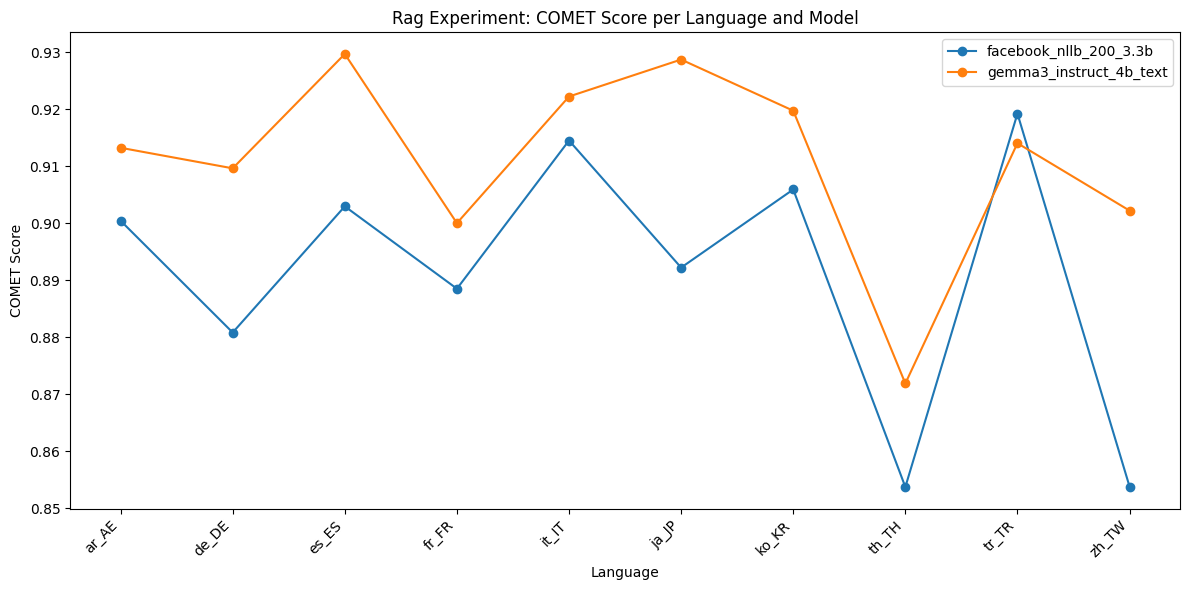

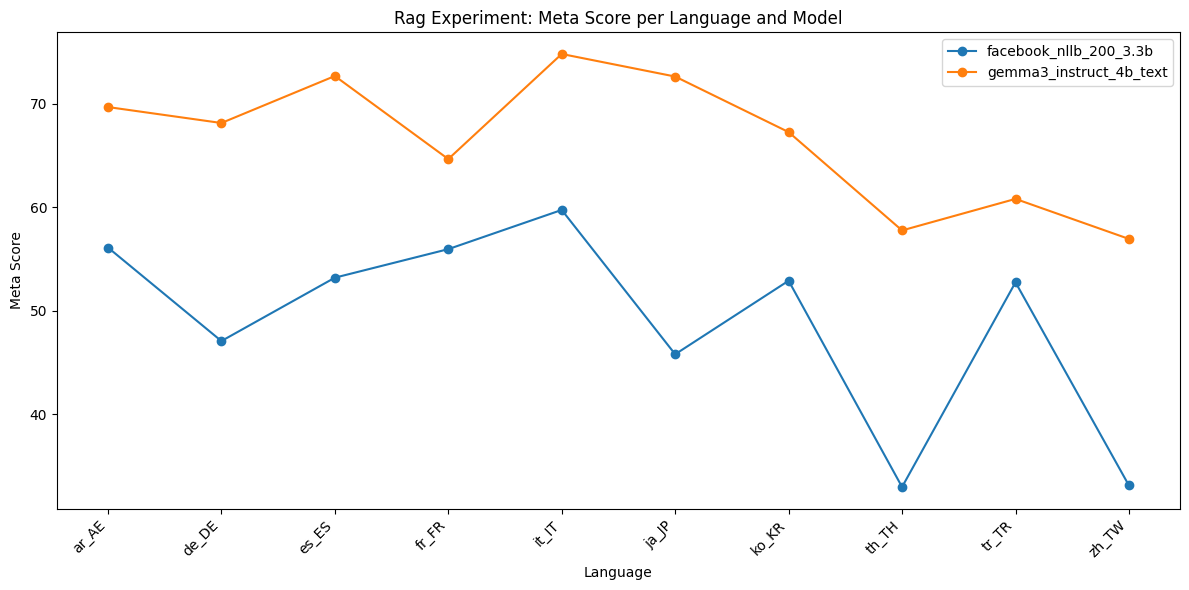


## Zeroshot Experiment

### Correct Instances Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT,ja_JP,ko_KR,th_TH,tr_TR,zh_TW
0,facebook_nllb_200_3.3b,211,193,301,249,276,66.0,193.0,34.0,188.0,18.0
1,gemini-2.0-flash,281,307,396,321,358,NaN,NaN,NaN,NaN,NaN
2,gemma3_instruct_4b_text,132,184,257,202,222,122.0,161.0,30.0,130.0,95.0
3,llama3.1_8b,74,166,243,187,215,66.0,52.0,24.0,106.0,67.0



### Total Instances Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT,ja_JP,ko_KR,th_TH,tr_TR,zh_TW
0,facebook_nllb_200_3.3b,722,731,739,724,730,723.0,745.0,710.0,732.0,722.0
1,gemini-2.0-flash,722,731,739,724,730,NaN,NaN,NaN,NaN,NaN
2,gemma3_instruct_4b_text,722,731,739,724,730,723.0,745.0,710.0,732.0,722.0
3,llama3.1_8b,722,731,739,724,730,723.0,745.0,710.0,732.0,722.0



### COMET Score Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT,ja_JP,ko_KR,th_TH,tr_TR,zh_TW
0,facebook_nllb_200_3.3b,0.894012,0.887837,0.914690,0.886039,0.901158,0.877546,0.909104,0.796988,0.908409,0.842765
1,gemini-2.0-flash,0.895801,0.902184,0.923279,0.881997,0.915130,NaN,NaN,NaN,NaN,NaN
2,gemma3_instruct_4b_text,0.870702,0.871655,0.911657,0.875383,0.889993,0.890555,0.897712,0.807715,0.888256,0.880877
3,llama3.1_8b,0.732168,0.794364,0.884256,0.821433,0.847478,0.766446,0.786775,0.708514,0.805609,0.760198



### Meta Score Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT,ja_JP,ko_KR,th_TH,tr_TR,zh_TW
0,facebook_nllb_200_3.3b,29.224377,26.402189,40.730717,34.392265,37.808219,9.128631,25.906040,4.788732,25.683060,2.493075
1,gemini-2.0-flash,38.919668,41.997264,53.585927,44.337017,49.041096,NaN,NaN,NaN,NaN,NaN
2,gemma3_instruct_4b_text,18.282548,25.170999,34.776725,27.900552,30.410959,16.874136,21.610738,4.225352,17.759563,13.157895
3,llama3.1_8b,10.249307,22.708618,32.882273,25.828729,29.452055,9.128631,6.979866,3.380282,14.480874,9.279778


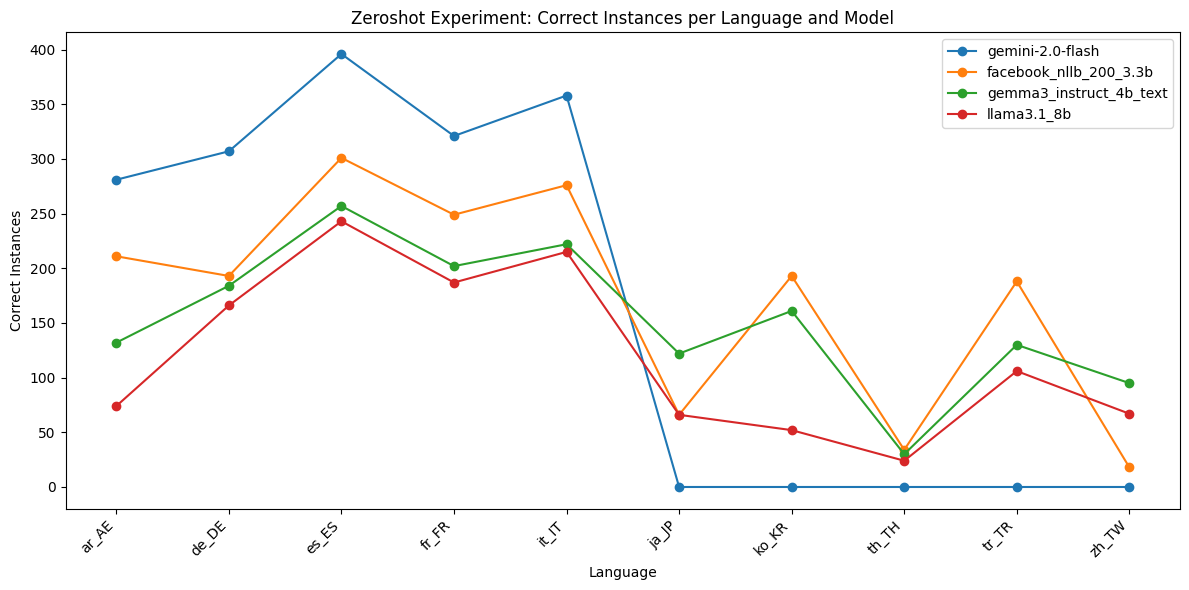

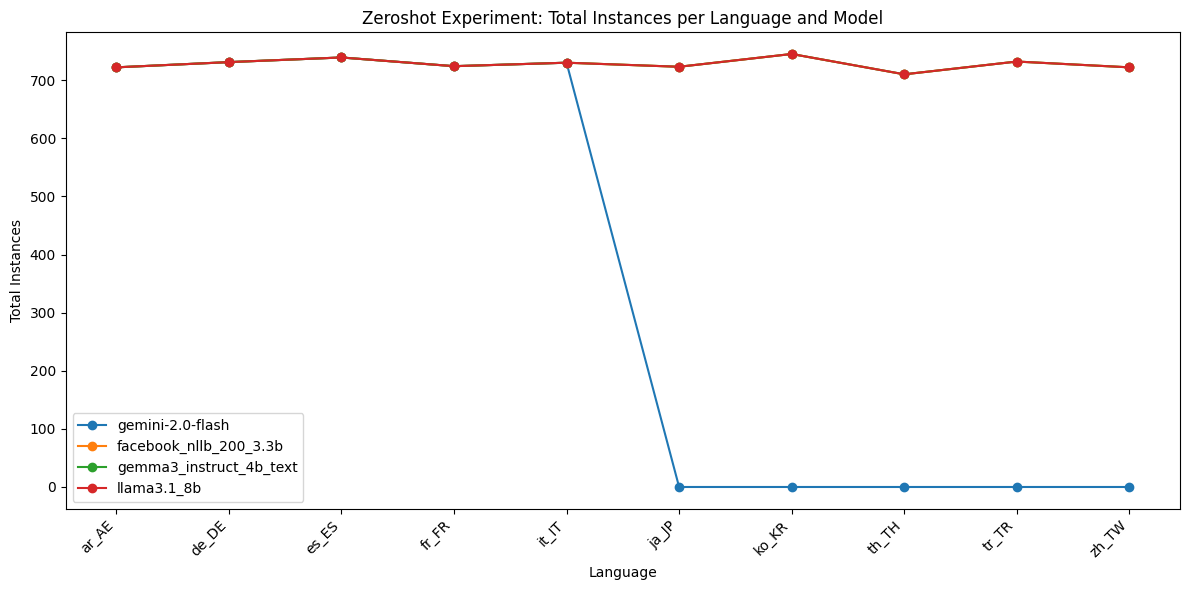

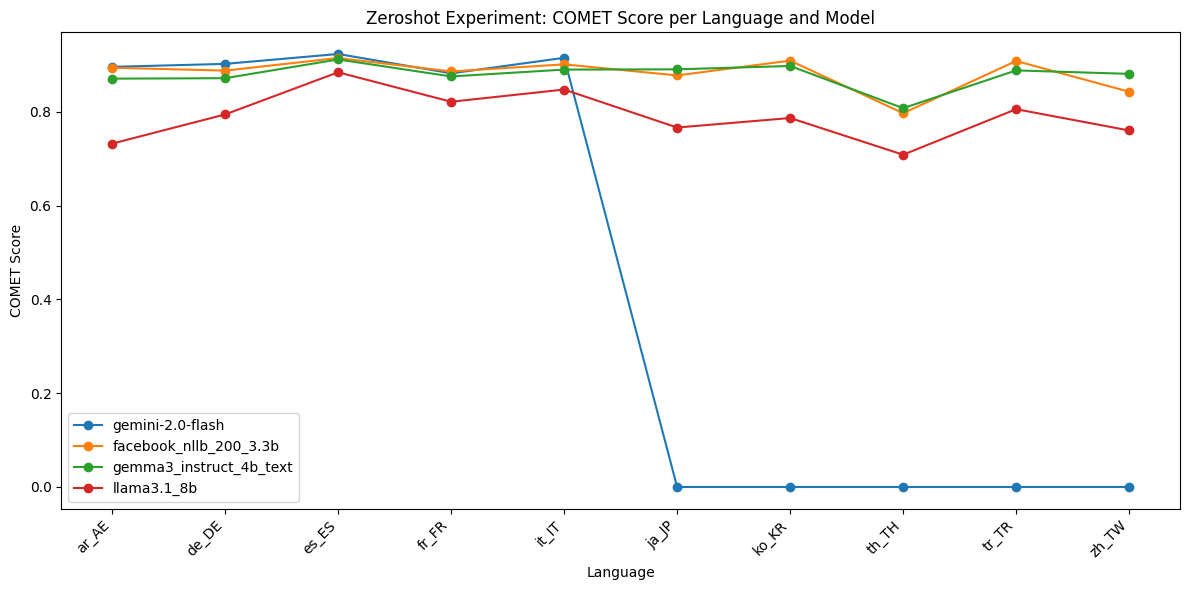

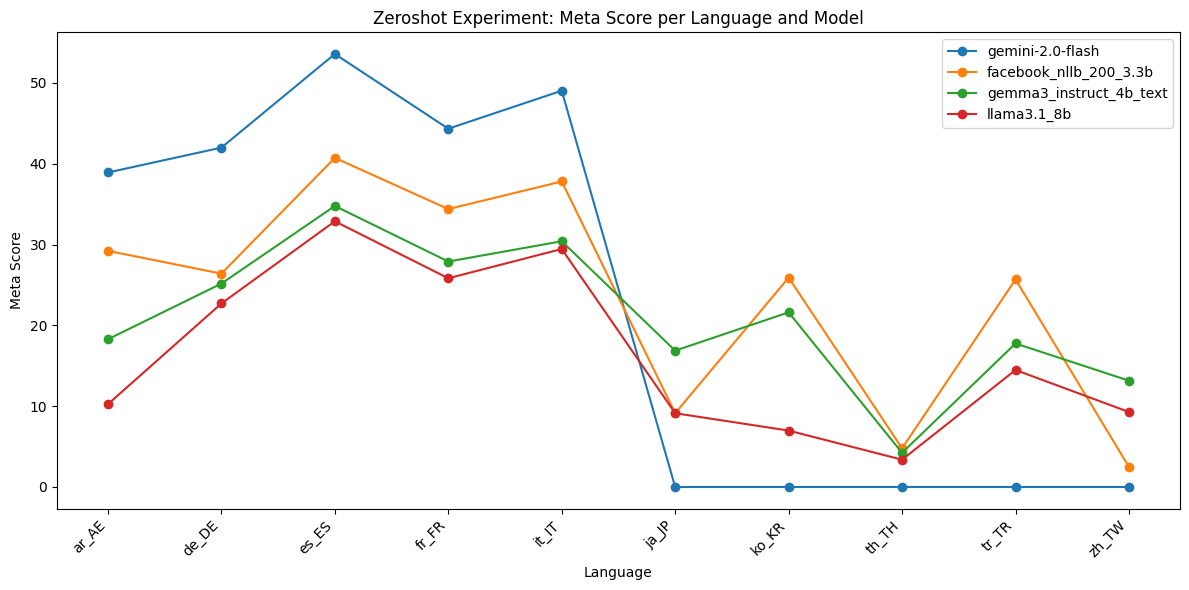


## Fewshot Experiment

### Correct Instances Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT,ja_JP,ko_KR,th_TH,tr_TR,zh_TW
0,gemini-2.0-flash,289,338,393,316,359,NaN,NaN,NaN,NaN,NaN
1,llama3.1_8b,74,132,234,178,182,30.0,35.0,15.0,105.0,75.0



### Total Instances Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT,ja_JP,ko_KR,th_TH,tr_TR,zh_TW
0,gemini-2.0-flash,722,731,739,724,730,NaN,NaN,NaN,NaN,NaN
1,llama3.1_8b,722,731,739,724,730,723.0,745.0,710.0,732.0,722.0



### COMET Score Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT,ja_JP,ko_KR,th_TH,tr_TR,zh_TW
0,gemini-2.0-flash,0.904642,0.901906,0.923532,0.899110,0.916286,NaN,NaN,NaN,NaN,NaN
1,llama3.1_8b,0.778907,0.792391,0.892918,0.764773,0.780366,0.701464,0.647615,0.662619,0.784995,0.772904



### Meta Score Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT,ja_JP,ko_KR,th_TH,tr_TR,zh_TW
0,gemini-2.0-flash,40.027701,46.238030,53.179973,43.646409,49.178082,NaN,NaN,NaN,NaN,NaN
1,llama3.1_8b,10.249307,18.057456,31.664411,24.585635,24.931507,4.149378,4.697987,2.112676,14.344262,10.387812


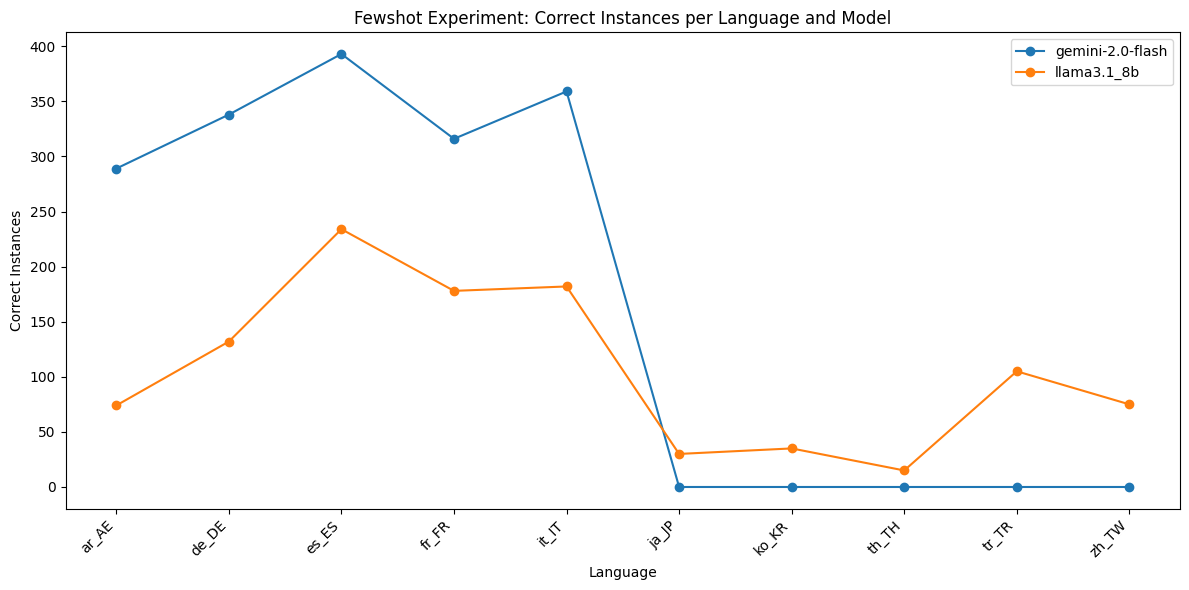

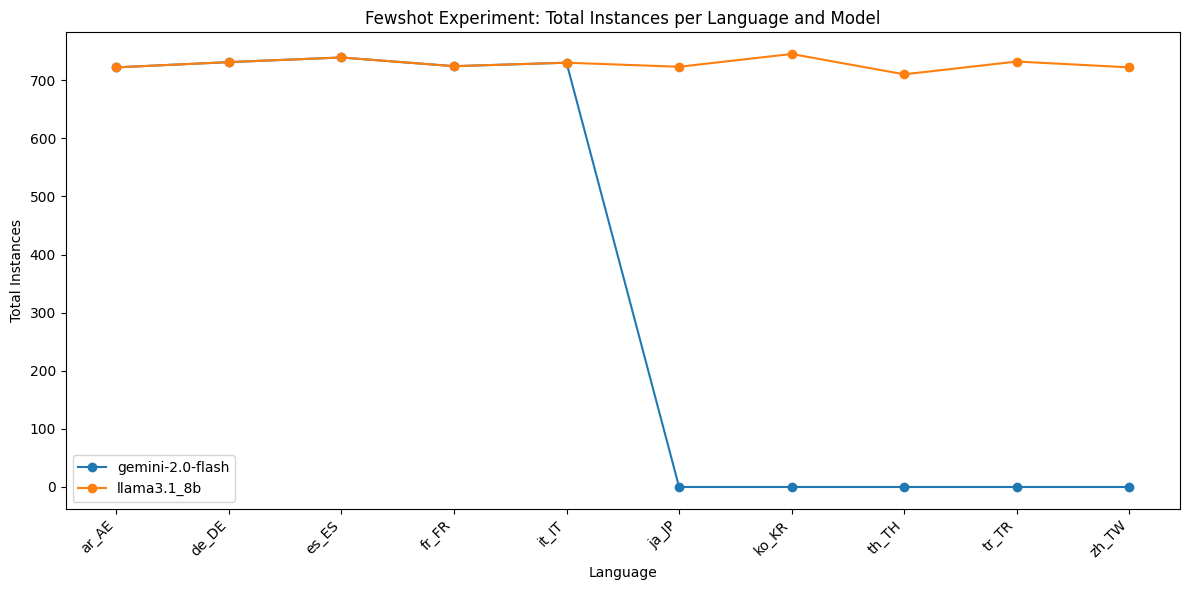

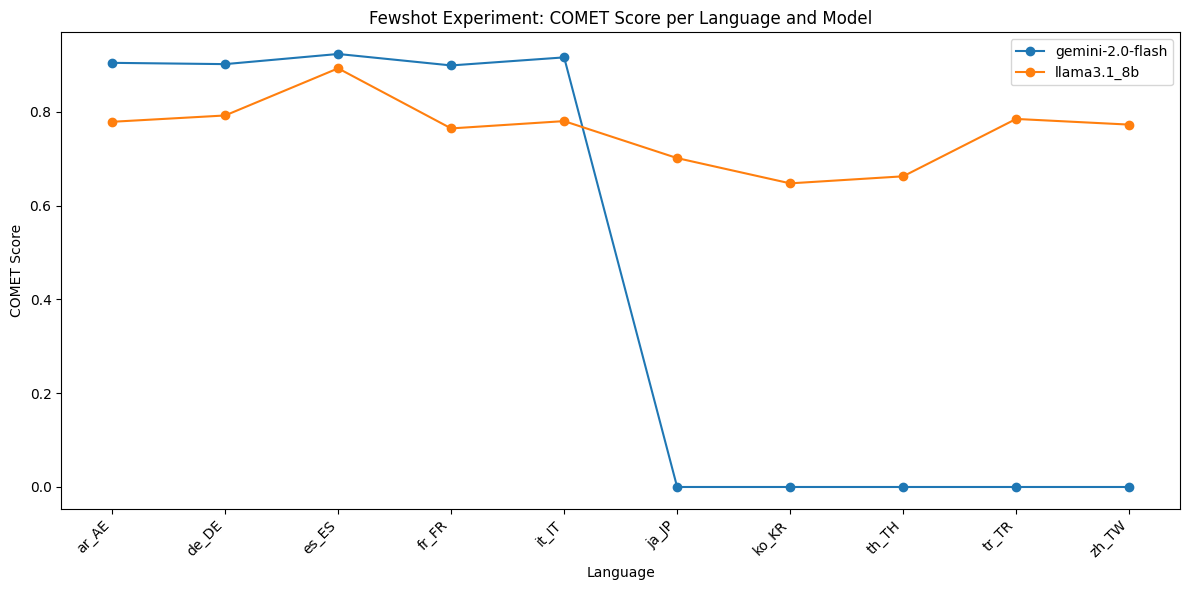

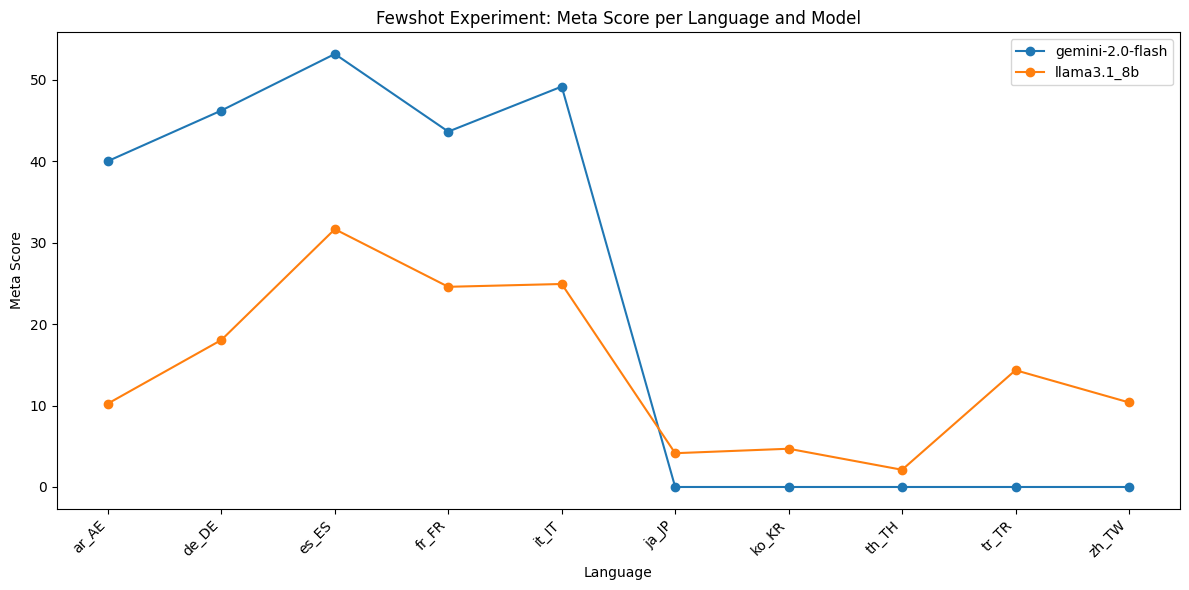


## Cot Experiment

### Correct Instances Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT
0,gemini-2.0-flash,265,309,382,326,307



### Total Instances Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT
0,gemini-2.0-flash,722,731,739,724,730



### COMET Score Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT
0,gemini-2.0-flash,0.898485,0.900797,0.922098,0.900923,0.910102



### Meta Score Table


,Model,ar_AE,de_DE,es_ES,fr_FR,it_IT
0,gemini-2.0-flash,36.703601,42.270862,51.691475,45.027624,42.054795


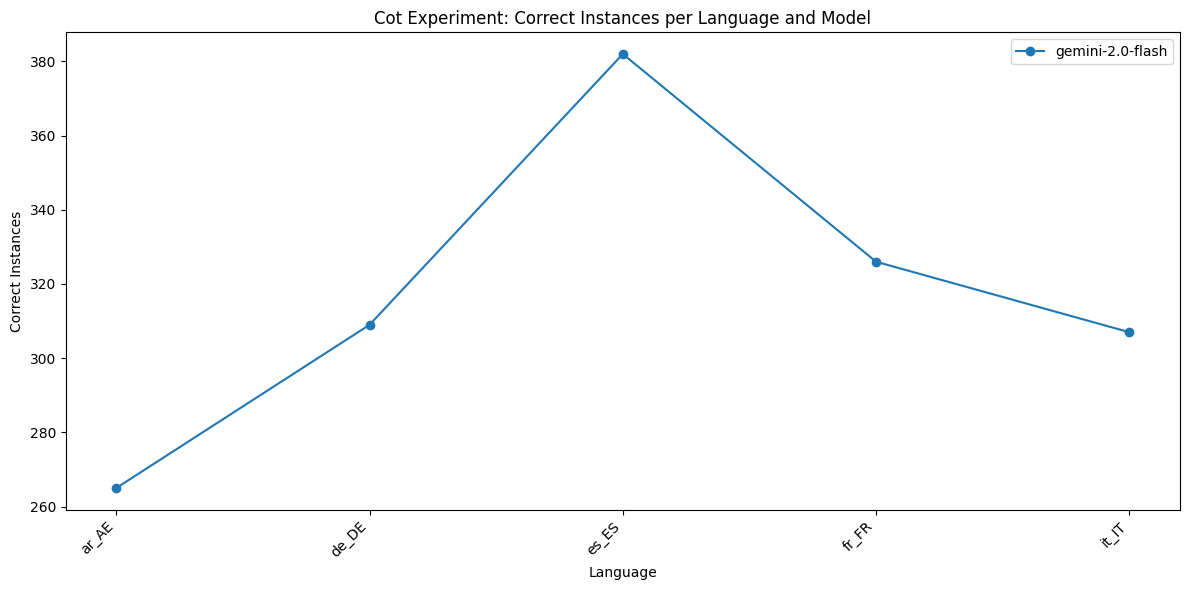

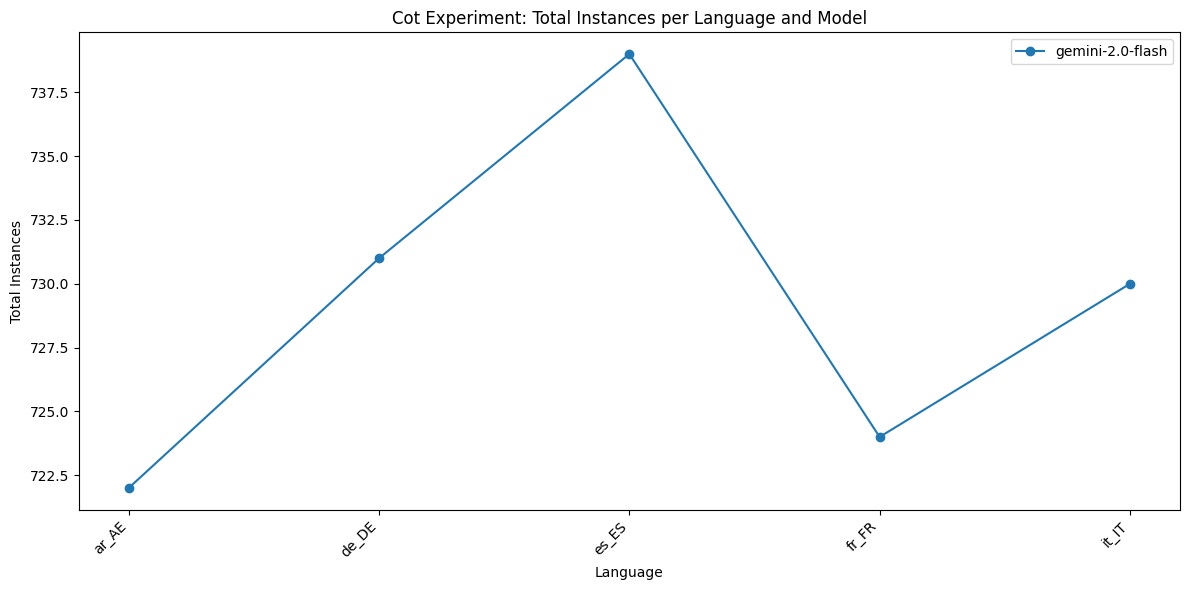

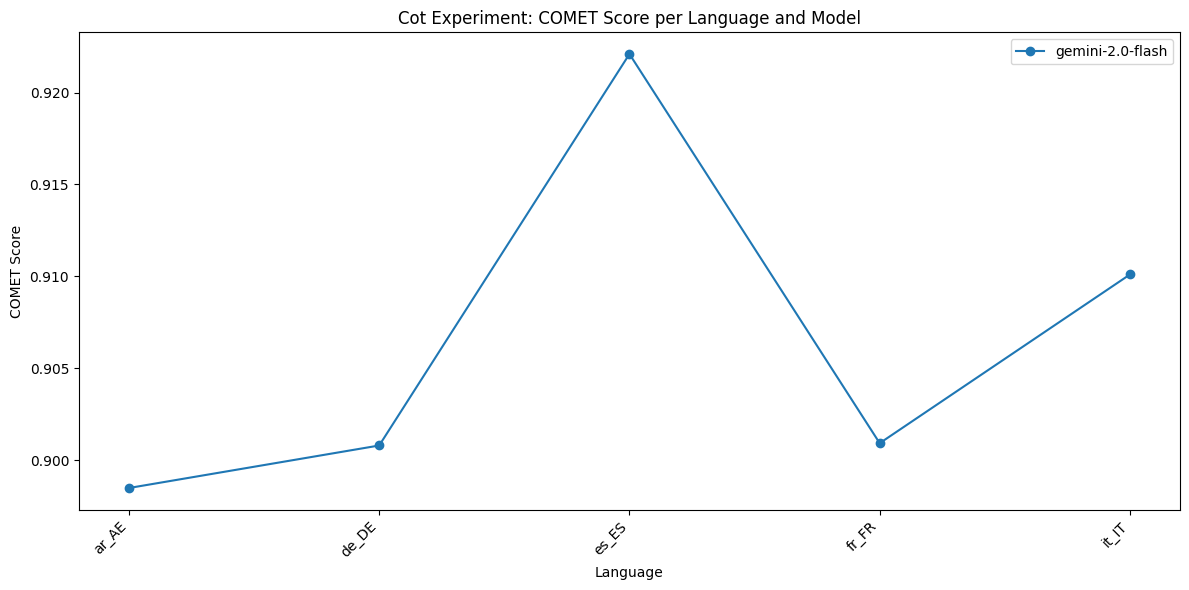

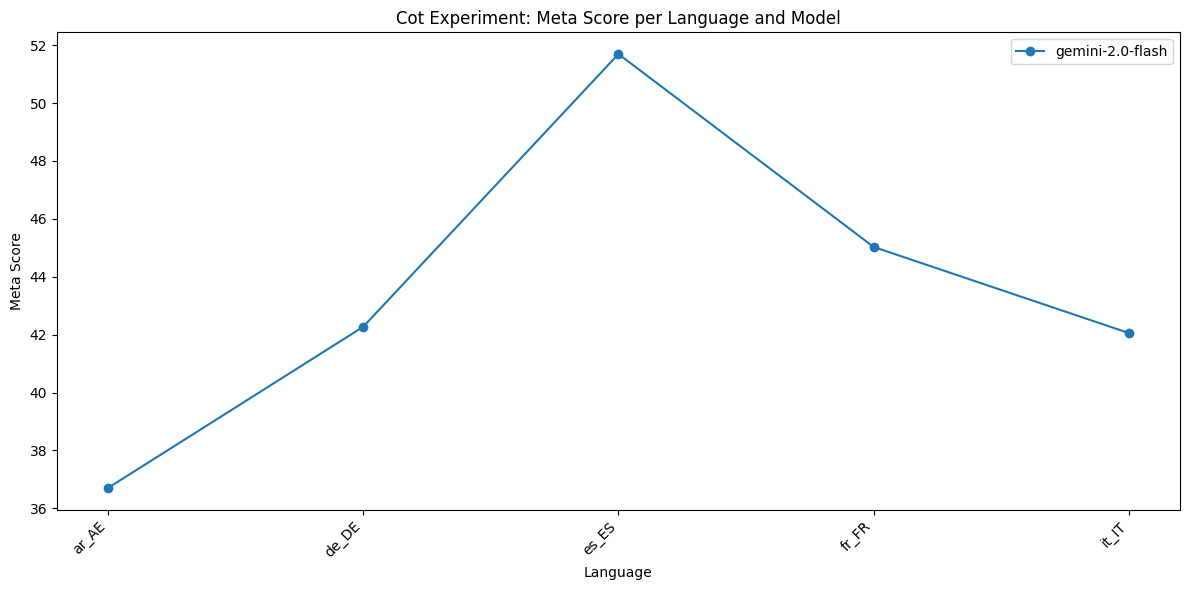

In [2]:
# For each experiment, create a table (one per metric, models as rows, languages as columns) and line graphs for all metrics
for exp_group in results:
    display_name = exp_group.capitalize()
    print(f"\n## {display_name} Experiment")
    exp_data = results[exp_group]
    # Collect all languages
    all_langs = set()
    for model in exp_data:
        all_langs.update(exp_data[model].keys())
    all_langs = sorted(list(all_langs))
    # Collect all models
    all_models = sorted(list(exp_data.keys()))
    # Metrics to report
    metrics_to_plot = [
        ("correct_instances", "Correct Instances"),
        ("total_instances", "Total Instances"),
        ("comet_score", "COMET Score"),
        ("meta_score", "Meta Score")
    ]
    # Create a table for each metric
    for metric_key, metric_label in metrics_to_plot:
        table_rows = []
        for model in all_models:
            row = {"Model": model}
            for lang in all_langs:
                value = exp_data[model].get(lang, {}).get(metric_key, None)
                row[lang] = value
            table_rows.append(row)
        metric_df = pd.DataFrame(table_rows)
        print(f"\n### {metric_label} Table")
        display(metric_df)
    # Line graphs for each metric (as before)
    for metric_key, metric_label in metrics_to_plot:
        plt.figure(figsize=(12, 6))
        for model in exp_data:
            values = [exp_data[model].get(lang, {}).get(metric_key, 0) for lang in all_langs]
            plt.plot(all_langs, values, marker='o', label=model)
        plt.title(f"{display_name} Experiment: {metric_label} per Language and Model")
        plt.ylabel(metric_label)
        plt.xlabel("Language")
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()